## Linear Regression

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('../data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
data.isnull().sum()
# no-NaN in the data

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# since I'm primarily interested in the amount of charges, I want to see which features are more correlated to it
# for a start， I encode categorical features

from sklearn.preprocessing import LabelEncoder

#sex
le = LabelEncoder()
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)

# smoker or not
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)

#region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)

https://www.kaggle.com/code/hely333/eda-regression/notebook
A few words about coding "region". In general, categorical variables with large variability are best encoded using OneHotEncoder and so on. But in this case, nothing will change, because there is no special order in which the regions would be listed. So I'm being very lazy only used the Label Encoder.

In [6]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [7]:
data.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


In [8]:
# 
data.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

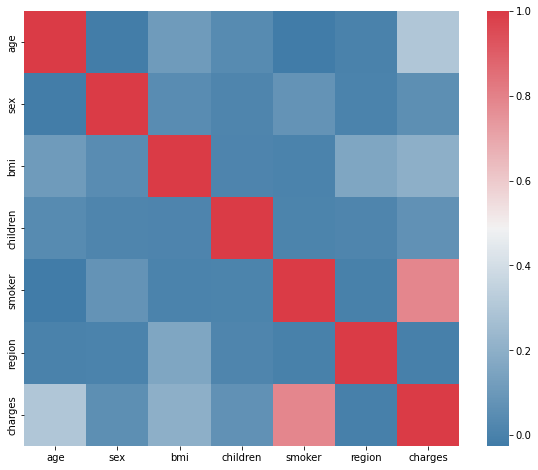

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)
plt.show();

A strong correlation is observed only with the fact of smoking the patient. To be honest, I expected a higher correlation with bmi. Well. We investigate smoking in more detail.

### Smoker vs Charges

In [10]:
# First, let's look at the distribution of charges. This will help us to know how much patients spend on treatment on average

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
import scipy.special
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

p = figure(title="Distribution of charges",tools="save",
            background_fill_color="#E8DDCB")
hist, edges = np.histogram(data.charges)
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
p.xaxis.axis_label = 'x'
p.yaxis.axis_label = 'Pr(x)'
# show(gridplot(p,ncols = 2, plot_width=400, plot_height=400, toolbar_location=None))

Loading BokehJS ...

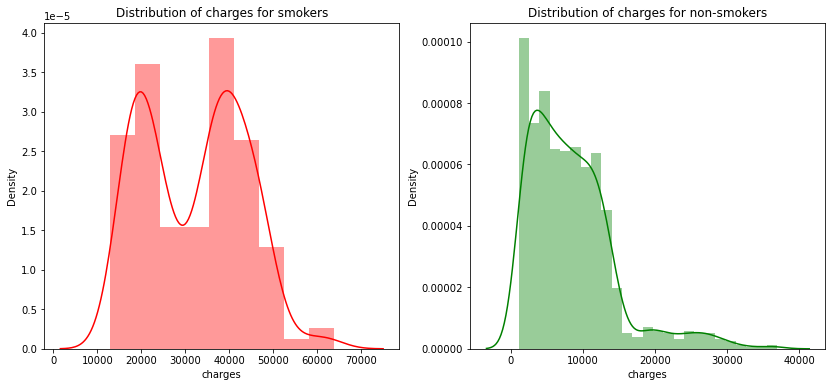

In [12]:
#
fig = plt.figure(figsize=(14,6))

ax = fig.add_subplot(121)
sns.distplot(data[(data.smoker == 1)]["charges"],color='r',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax = fig.add_subplot(122)
sns.distplot(data[(data.smoker == 0)]['charges'],color= 'g',ax=ax)
ax.set_title('Distribution of charges for non-smokers');

# Smoking patients spend more on treatment.
# But there is a feeling that the number of non-smoking patients is greater. Going to check it.

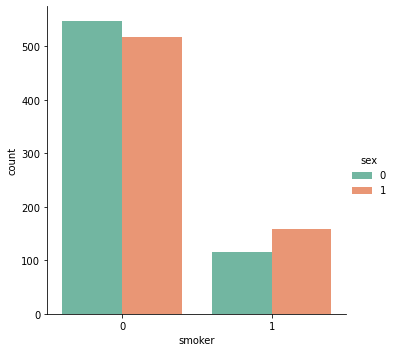

In [13]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="Set2", data=data)
plt.show();

# Please note that women are coded with the symbol " 1 "and men - "0". 
# Also we can notice that more male smokers than women smokers. It can be assumed that the total cost of treatment in men will be more than in women, given the impact of smoking.
# Maybe we'll check it out later. Add some more useful visualizations.

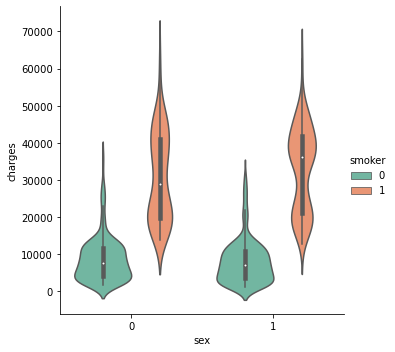

In [14]:
sns.catplot(x="sex", y="charges", hue="smoker", 
            kind="violin", data=data, palette = 'Set2')

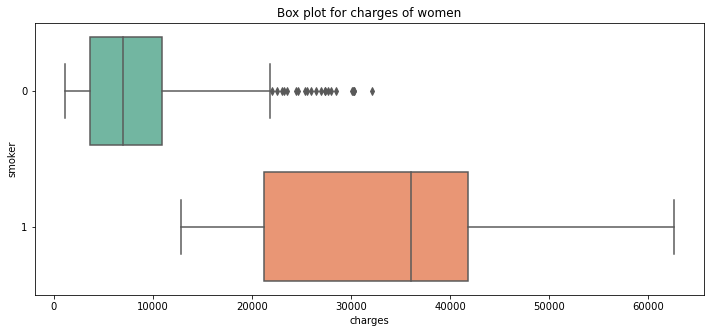

In [15]:
# women only
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data = data[(data.sex == 1)] , orient="h", palette= 'Set2')
plt.show();

<AxesSubplot:title={'center':'Box plot for charges of men'}, xlabel='charges', ylabel='smoker'>

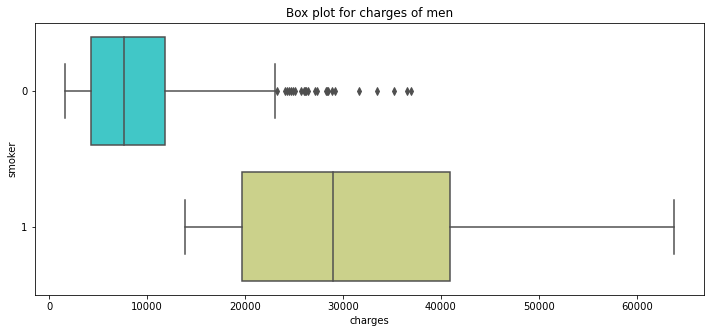

In [16]:
# men only
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of men")
sns.boxplot(y="smoker", x="charges", data = data[(data.sex == 0)] , orient="h", palette = 'rainbow')

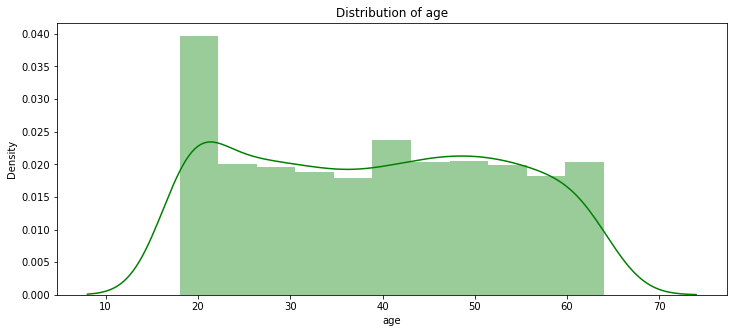

In [17]:
# Now let's pay attention to the age of the patients. 
# First, let's look at how age affects the cost of treatment, and also look at patients of what age more in our data set.
plt.figure(figsize=(12,5))
plt.title("Distribution of age")
ax = sns.distplot(data["age"], color = 'g')

# min:18 and max age =64

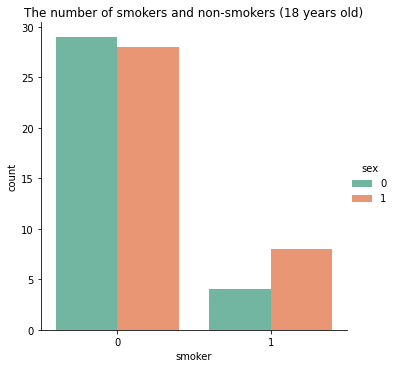

In [18]:
# My personal interest is whether there are smokers among patients 18 years
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="Set2", data=data[(data.age == 18)])
plt.title("The number of smokers and non-smokers (18 years old)")
plt.show();

<AxesSubplot:title={'center':'Box plot for charges 18 years old smokers'}, xlabel='charges', ylabel='smoker'>

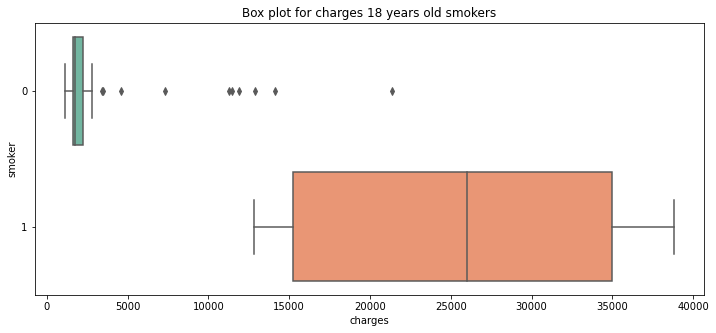

In [19]:
# Does smoking affect the cost of treatment at this age?
plt.figure(figsize=(12,5))
plt.title("Box plot for charges 18 years old smokers")
sns.boxplot(y="smoker", x="charges", data = data[(data.age == 18)] , orient="h", palette = 'Set2')

# As we can see, even at the age of 18 smokers spend much more on treatment than non-smokers. Among non-smokers we are seeing some " tails." I can assume that this is due to serious diseases or accidents. 


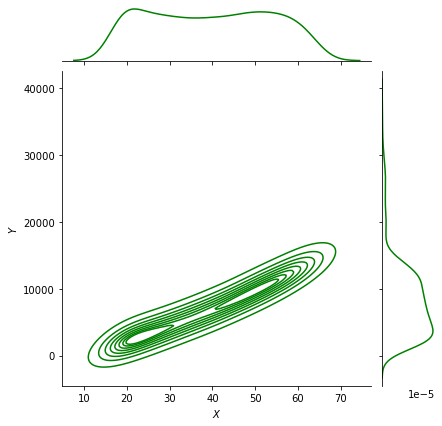

In [21]:
# Now let's see how the cost of treatment depends on the age of smokers and non-smokers patients.
# Non-smoker
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 0)],kind="kde", color="g")

g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for non-smokers')
plt.show();

Text(0.5, 1.0, 'Distribution of charges and age for smokers')

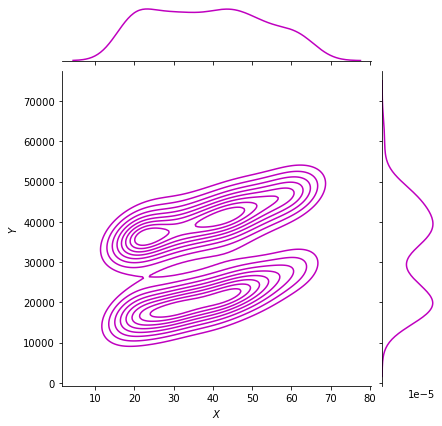

In [23]:
# smoker
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 1)],kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for smokers')

In [24]:
#non - smokers
p = figure(plot_width=500, plot_height=450)
p.circle(x=data[(data.smoker == 0)].age,y=data[(data.smoker == 0)].charges, size=7, line_color="navy", fill_color="green", fill_alpha=0.9)

show(p)

In [25]:
#smokers
p = figure(plot_width=500, plot_height=450)
p.circle(x=data[(data.smoker == 1)].age,y=data[(data.smoker == 1)].charges, size=7, line_color="navy", fill_color="red", fill_alpha=0.9)
show(p)

Text(0.5, 1.0, 'Smokers and non-smokers')

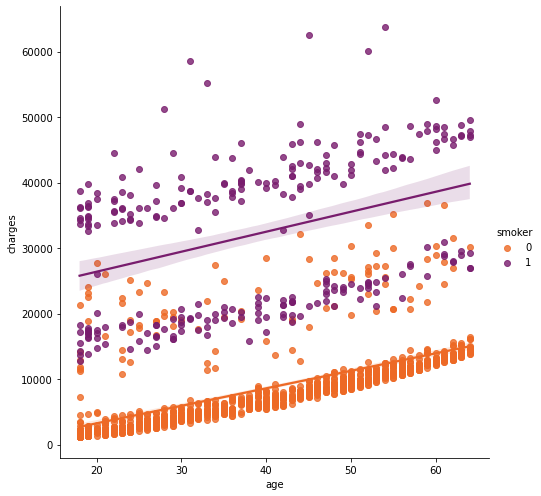

In [26]:
sns.lmplot(x="age", y="charges", hue="smoker", data=data, palette = 'inferno_r', size = 7)
ax.set_title('Smokers and non-smokers')

# This function combines regplot() and FacetGrid. 
# It is intended as a convenient interface to fit regression models across conditional subsets of a dataset.
# When thinking about how to assign variables to different facets, a general rule is that it makes sense to use hue for the most important comparison, followed by col and row.
# However, always think about your particular dataset and the goals of the visualization you are creating.

In non-smokers, the cost of treatment increases with age. That makes sense. 
In smoking people, we do not see such dependence. I think that it is not only in smoking but also in the peculiarities of the dataset. Such a strong effect of Smoking on the cost of treatment would be more logical to judge having a set of data with a large number of records and signs. But we work with what we have! Let's pay attention to bmi. I am surprised that this figure but affects the cost of treatment in patients. Or are we on a diet for nothing?

### BMI vs Charges

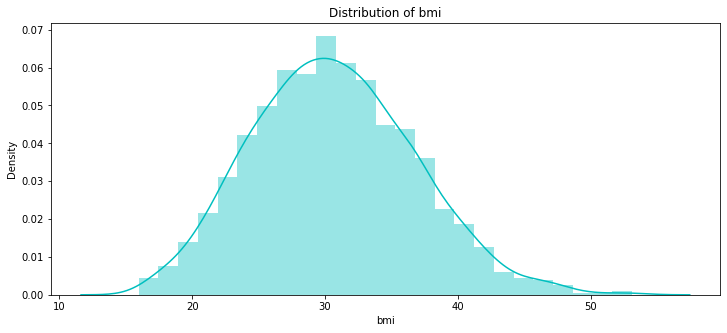

In [27]:
plt.figure(figsize=(12,5))
plt.title("Distribution of bmi")
ax = sns.distplot(data["bmi"], color = 'c')

# There's something insanely beautiful about this distribution, isn't there?
# The average BMI in patients is 30. I think I should go to the great Google with a question about this indicator.
# With a value equal to 30 starts obesity. I also calculated my BMI and now I can safely eat a sandwich. Let's start to explore!
# First, let's look at the distribution of costs in patients with BMI greater than 30 and less than 30.

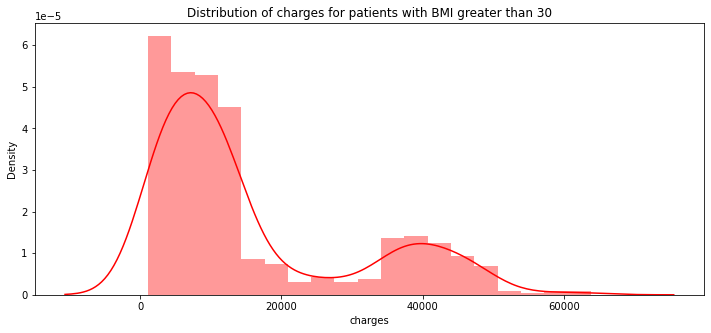

In [28]:
# bmi > 30
plt.figure(figsize=(12,5))
plt.title("Distribution of charges for patients with BMI greater than 30")
ax = sns.distplot(data[(data.bmi >= 30)]['charges'], color = 'r')

# Patients with BMI above 30 spend more on treatment!

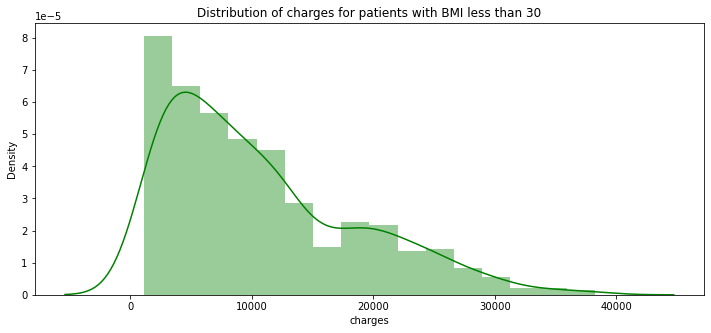

In [30]:
#  bmi < 30
plt.figure(figsize=(12,5))
plt.title("Distribution of charges for patients with BMI less than 30")
ax = sns.distplot(data[(data.bmi < 30)]['charges'], color = 'g')

Text(0.5, 1.0, 'Distribution of bmi and charges')

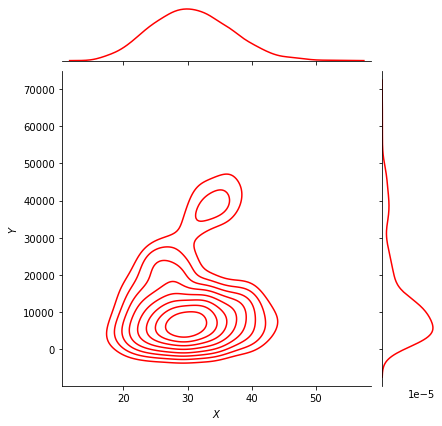

In [31]:
g = sns.jointplot(x="bmi", y="charges", data = data,kind="kde", color="r")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of bmi and charges')

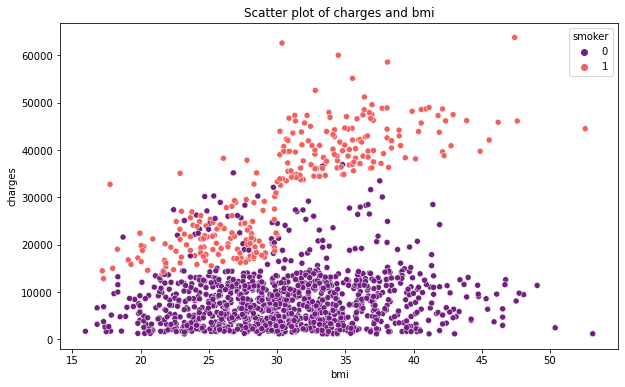

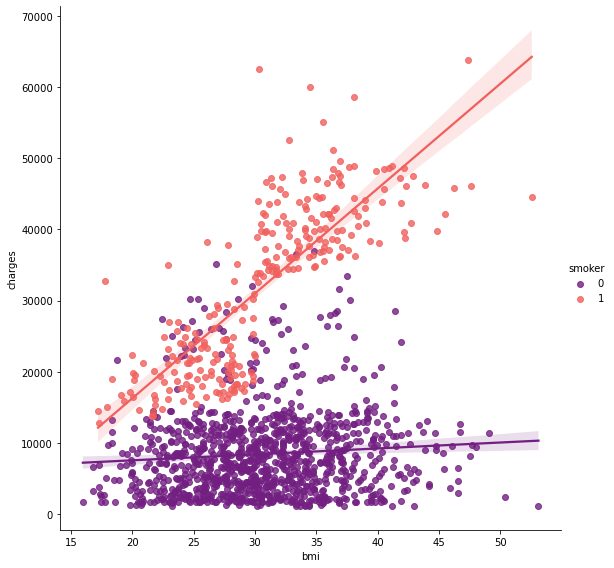

In [33]:
# BMI ~ charges ~ smoker
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='charges',data=data,palette='magma',hue='smoker')
ax.set_title('Scatter plot of charges and bmi')

sns.lmplot(x="bmi", y="charges", hue="smoker", data=data, palette = 'magma', size = 8)
plt.show();

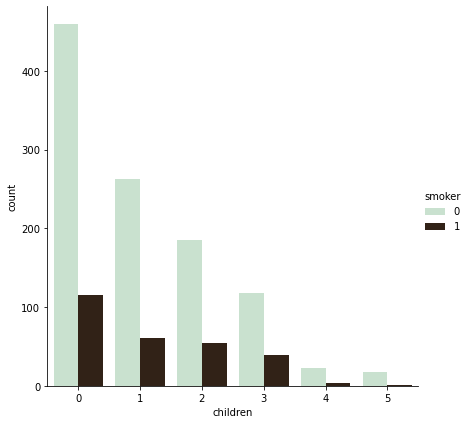

In [34]:
# Let's pay attention to children. First, let's see how many children our patients have.
sns.catplot(x="children", kind="count", palette="ch:25", data=data, hue='smoker', size = 6)

Text(0.5, 1.0, 'Smokers and non-smokers who have childrens')

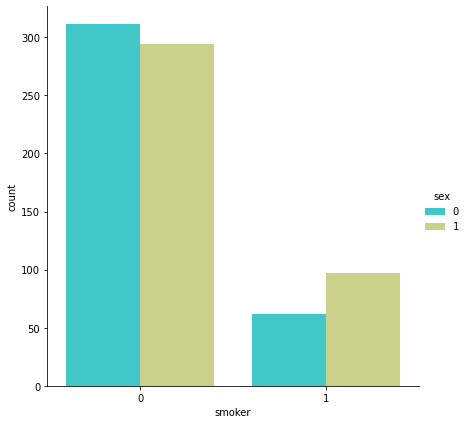

In [35]:
# Most patients do not have children. I wonder if people who have children smoke.
sns.catplot(x="smoker", kind="count", palette="rainbow",hue = "sex",
            data=data[(data.children > 0)], size = 6)
ax.set_title('Smokers and non-smokers who have childrens')

# non-smoking parents are much more!

In [36]:
# use Linear regresstion to predict the cost of treatment
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [37]:
x = data.drop(['charges'], axis = 1)
y = data.charges

x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 0)

lr = LinearRegression().fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print(lr.score(x_test,y_test))

# Not bad for such a lazy implementation, even without data normalization

0.7962732059725786


In [38]:
# let's add polynomial signs. And look at the result.
X = data.drop(['charges','region'], axis = 1)
Y = data.charges


quad = PolynomialFeatures(degree = 2)
x_quad = quad.fit_transform(X)

X_train,X_test,Y_train,Y_test = train_test_split(x_quad,Y, random_state = 0)

plr = LinearRegression().fit(X_train,Y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print(plr.score(X_test,Y_test))

0.8849197344147236


In [39]:
# the model predicts well the cost of treatment of patients. I think we could limit ourselves to creating two or three polynomial features, but the data set is so small, so we went the easy way.
# And finally try RandomForestRegressor

forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 0,
                              n_jobs = -1)
forest.fit(x_train,y_train)
forest_train_pred = forest.predict(x_train)
forest_test_pred = forest.predict(x_test)

print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(y_train,forest_train_pred),
mean_squared_error(y_test,forest_test_pred)))

print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,forest_train_pred),
r2_score(y_test,forest_test_pred)))

MSE train data: 3744526.416, MSE test data: 20337176.372
R2 train data: 0.974, R2 test data: 0.871


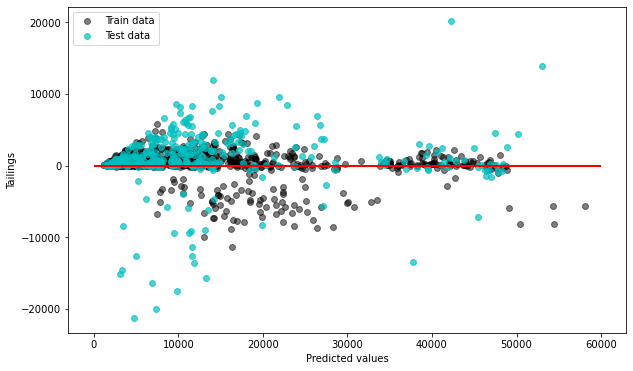

In [40]:
plt.figure(figsize=(10,6))

# train data
plt.scatter(forest_train_pred,forest_train_pred - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')

# test data
plt.scatter(forest_test_pred,forest_test_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')

plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
plt.show();

# Good result. But we see a noticeable retraining of the model on the training data